### Betfair Historical Data demonstration and testing
1. Demonstrating how to download and open data from the Betfair Historical Data service.
2. Adding some useful variables for the purposes of data analysis
3. Using `matplotlib` to visualise price and volume data for a given horse.


To connect to the Betfair API through betfairlightweight, you must have first set up your API certificates and saved the login details in dictionary format in a file called `api_logins.json` in the project home directory (`/betfair_project`). The following connects and should return `<LoginResource>` if successful.

In [13]:
import betfairlightweight
from betfairlightweight import filters
import pandas as pd
import numpy as np
import os
import datetime
import json
from pathlib import Path, PurePath #To define open and save locations that are cross-compatible between Windows/Linux
from bz2 import BZ2File #To unzip the Betfair data from its downloaded format
import matplotlib.pyplot as plt

project_dir = Path.cwd().parents[1]
logins_dir = project_dir / 'api_logins.json'

with open(logins_dir) as f:
    login_dict =  json.load(f)
    
trading = betfairlightweight.APIClient(username=login_dict['my_username'],
                                       password=login_dict['my_password'],
                                       app_key=login_dict['my_app_key'],
                                       certs=login_dict['certs_path'])

trading.login()

<LoginResource>

To perform the following, you must have purchased data from the [Betfair Historical data service](https://historicdata.betfair.com/#/home). Advanced data for all sports has been offered for free for Jan - May 2020. To understand more about what different packages of data include, look in the data dictionaries folder in this project.

The following lists the data that you have purchased on your Betfair account. Since data is purchased by month, that is how it is represented here:

In [14]:
my_data = trading.historic.get_my_data()
for i in my_data:
    print(i)

{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-01-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-02-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-03-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-04-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-05-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Pro Plan', 'forDate': '2020-04-01T00:00:00', 'purchaseItemId': 41353}
{'sport': 'Horse Racing', 'plan': 'Pro Plan', 'forDate': '2020-05-01T00:00:00', 'purchaseItemId': 41353}


For our purposes, we will want to select relatively small subset of the data available from the months of data above. The following selects just the data for from 01/01/20 to 01/03/20 and returns a dictionary of the contents of the data which we go on to use to download specific country/race/market types, and tells us the size of the entire selection:

In [15]:
collection_options = trading.historic.get_collection_options(
    "Horse Racing", "Advanced Plan", 1, 1, 2020, 1, 3, 2020
)

print(collection_options)

basket_size = trading.historic.get_data_size(
    "Horse Racing", "Advanced Plan", 1, 1, 2020, 1, 3, 2020
)
print(basket_size)

{'marketTypesCollection': [{'name': '', 'count': 1998}, {'name': 'ANTEPOST_WIN', 'count': 22}, {'name': 'DAILY_WIN_DIST', 'count': 1}, {'name': 'EACH_WAY', 'count': 1788}, {'name': 'FORECAST', 'count': 438}, {'name': 'MATCH_BET', 'count': 1692}, {'name': 'OTHER_PLACE', 'count': 4746}, {'name': 'PLACE', 'count': 9161}, {'name': 'RACE_WIN_DIST', 'count': 175}, {'name': 'REV_FORECAST', 'count': 784}, {'name': 'WIN', 'count': 11923}, {'name': 'WITHOUT_FAV', 'count': 306}], 'countriesCollection': [{'name': 'AE', 'count': 511}, {'name': 'AU', 'count': 11874}, {'name': 'ES', 'count': 6}, {'name': 'FR', 'count': 549}, {'name': 'GB', 'count': 10230}, {'name': 'HK', 'count': 1}, {'name': 'IE', 'count': 2147}, {'name': 'NZ', 'count': 2016}, {'name': 'SA', 'count': 44}, {'name': 'SG', 'count': 314}, {'name': 'US', 'count': 4038}, {'name': 'ZA', 'count': 1304}], 'fileTypeCollection': [{'name': 'E', 'count': 1998}, {'name': 'M', 'count': 31036}]}
{'totalSizeMB': 5731, 'fileCount': 33034}


To dig into particular dates, countries, race types and market types we use `.get_file_list()`, specifying our filtering parameters. For example, you can see above that within the sub-dictionary for `'marketTypesCollection'` we have `'WIN'`, among others. 

The following retrieves a list of the event files that match these parameters. We select only data for 01/02/20, for the `'WIN'` market only and in `'GB'`.

In [16]:
file_list = trading.historic.get_file_list(
    "Horse Racing",
    "Advanced Plan",
    from_day=1,
    from_month=2,
    from_year=2020,
    to_day=1,
    to_month=2,
    to_year=2020,
    market_types_collection=["WIN"],
    countries_collection=["GB"],
    file_type_collection=["M"]\
    ,
)
print(file_list)

['/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130661.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096552.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136214.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133543.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130666.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096559.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136219.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130671.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133548.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096566.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136224.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133553.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130676.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168130245.bz2', '/xds

To downoad a file, `download_file()` is used, where we specify the download location (on Betfair) in `file_path` and the directory to which it is saved in `store_directory`. The filename is kept as is from Betfair. We both download the file and use the command to assign the file's location to the variable `download` so we can use it in subsequent operations.

`file_path` can be a list input, however, only the second file within that list is downloaded below.

In [17]:
data_dir = project_dir / 'data' / 'raw' / 'api'
file = file_list[1]
print(file)
download = trading.historic.download_file(file_path = file, store_directory = data_dir)
print(download)

/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096552.bz2
C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168096552.bz2


The downloaded file is .json formatted compressed in a bzip2 (.bz2) folder. The following extracts the file where it is downloaded. It is given no file extension, however it remains in .txt format and is readable in any text reader.

In [18]:
filename = str(download)
zipfile = BZ2File(filename) # open the file
data = zipfile.read() # get the decompressed data
newfilepath = filename[:-4] # assuming the filepath ends with .bz2, removing the extension and saving without a filetype
open(newfilepath, 'wb').write(data) # write an uncompressed file
zipfile.close()

## Using stream listener to read extracted data

We now have a readable raw text file in Betfair's dictionary format. To interpret the data with python, betfairlightweight includes a stream listener which will interpret the input of historical data in the same way that it does for live data. The below is edited from [here](https://github.com/liampauling/betfair/blob/104ff4cb8734038cb9351e74d16dc7bd018111bc/examples/examplestreaminghistorical.py). 

This finds the chosen variables in the data file and outputs them in a .csv format in output.txt. Note: output.txt is ignored by git and is not uploaded into the repository.

In [33]:
from betfairlightweight import StreamListener
from betfairlightweight.streaming.stream import MarketStream

class HistoricalStream(MarketStream):
    # create custom listener and stream

    def __init__(self, listener):
        super(HistoricalStream, self).__init__(listener)

    def on_process(self, market_books):
        
        for market_book in market_books:
            for runner in market_book.runners:
                market_def = market_book.market_definition
                runners_dict = {(runner.selection_id, runner.handicap): runner for runner in market_def.runners}
                runner_def = runners_dict.get((runner.selection_id, runner.handicap))
        
        time = []
        marketid = []
        status = []
        inplay = []
        selectionid = []
        lastpricetraded = []
        totalmatched = []
        sp = []
        adjfactor = []
        runnerstatus = []
        mkttotalmatched = []
        
        for market_book in market_books:
            for runner in market_book.runners:
                time.append(market_book.publish_time)
                marketid.append(market_book.market_id)
                status.append(market_book.status)
                inplay.append(market_book.inplay)
                selectionid.append(runner.selection_id)
                lastpricetraded.append(runner.last_price_traded)
                totalmatched.append(runner.total_matched)
                sp.append(runner.sp.actual_sp)
                adjfactor.append(runner.adjustment_factor)
                runnerstatus.append(runner.status)
                mkttotalmatched.append(market_book.total_matched)
        
        global datadict
        
        datadict = {'Time': time, 'MarketId' : marketid, 'Status' : status, 'Inplay' : inplay, \
            'SelectionId' : selectionid, 'LastPriceTraded' : lastpricetraded, 'TotalMatched' : totalmatched, \
            'Sp' : sp, 'AdjFactor' :  adjfactor, 'RunnerStatus' : runnerstatus, 'MktTotalMatched' : mkttotalmatched}
                

class HistoricalListener(StreamListener):
    def _add_stream(self, unique_id, stream_type):
        if stream_type == "marketSubscription":
            return HistoricalStream(self)
        
listener = HistoricalListener(max_latency=None)

stream = trading.streaming.create_historical_stream(
    directory=newfilepath,
    listener=listener,
)

stream.start()

The following variables (followed by their type) could also be included, but they must be iterated through in the same way that runners is, therein data can be retrieved.

`
runner.matches or "", #list[RunnerBookMatch]
runner.orders or "", #list[RunnerBookOrder]
runner.ex.available_to_lay,
runner.ex.available_to_back,
runner.ex.traded_volume,`

The following are empty in the Advanced data. Some may work in the Pro data:

`
runner.sp.back_stake_taken or "",
runner.sp.far_price or "",
market_book.last_match_time or "", #datetime.datetime   
runner.sp.lay_liability_taken or "",
runner.sp.near_price or "",
runner.removal_date or "", #datetime.datetime
market_book.total_available or "", #float'`

We can now read output.txt with pandas.

In [37]:
df = pd.DataFrame(datadict)
df.sort_values(by='Time')
df.head(10)

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,RunnerStatus,MktTotalMatched
0,2020-02-01 12:47:18.520,1.168096552,CLOSED,True,18286408,1000.00,161250.04,2.57,38.46,LOSER,0.0
1,2020-02-01 12:47:18.520,1.168096552,CLOSED,True,26640937,1000.00,29983.79,14.00,7.69,LOSER,0.0
2,2020-02-01 12:47:18.520,1.168096552,CLOSED,True,21580749,1000.00,74843.16,6.80,17.54,LOSER,0.0
3,2020-02-01 12:47:18.520,1.168096552,CLOSED,True,27706761,1000.00,3464.93,95.00,1.00,LOSER,0.0
4,2020-02-01 12:47:18.520,1.168096552,CLOSED,True,52106,1.01,225701.07,2.81,34.25,WINNER,0.0
5,2020-02-01 12:47:18.520,1.168096552,CLOSED,True,24608298,1000.00,6153.44,47.43,1.05,LOSER,0.0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time             6 non-null      datetime64[ns]
 1   MarketId         6 non-null      object        
 2   Status           6 non-null      object        
 3   Inplay           6 non-null      bool          
 4   SelectionId      6 non-null      int64         
 5   LastPriceTraded  6 non-null      float64       
 6   TotalMatched     6 non-null      float64       
 7   Sp               6 non-null      float64       
 8   AdjFactor        6 non-null      float64       
 9   RunnerStatus     6 non-null      object        
 10  MktTotalMatched  6 non-null      float64       
dtypes: bool(1), datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 478.0+ bytes


In [35]:
df.describe() #descriptive statistics for this data.

,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,MktTotalMatched
count,6.000000e+00,6.000000,6.000000,6.000000,6.000000,6.0
mean,1.981254e+07,833.501667,83566.071667,28.101667,16.665000,0.0
std,1.027497e+07,407.835960,91206.595399,36.859528,16.460808,0.0
min,5.210600e+04,1.010000,3464.930000,2.570000,1.000000,0.0
25%,1.910999e+07,1000.000000,12111.027500,3.807500,2.710000,0.0
50%,2.309452e+07,1000.000000,52413.475000,10.400000,12.615000,0.0
75%,2.613278e+07,1000.000000,139648.320000,39.072500,30.072500,0.0
max,2.770676e+07,1000.000000,225701.070000,95.000000,38.460000,0.0


### Creating variables for better analysis

For the purposes of data analysis and comparability, we want to create some new variables.

As it stands, `TotalMatched` is a cumulative figure relating to `LastPriceTraded` on the same row - it is the total matched at that price. To understand the evolution of matches at each price, we can create `TradeSize` by looking at the change in `TotalMatched` grouped by `LastPriceTraded`.

In [22]:
df['TradeSize'] = df.groupby(['SelectionId', 'LastPriceTraded'])['TotalMatched'].diff()

In order to make race timeseries data comparable between events, we need an indicator of what stage the market is in. For example, betting behaviour is very different when the market is first created compared to in the 5 minutes before the off, or compared to in play. A logical anchoring point is the moment in which the race starts, at which point BSP is also defined.

`TimeIndex` is created with time-zero defined at the second where `Inplay == True` for the first time, counting positively and negatively in either direction **in seconds**. 

In [23]:
#This gives the value of the 0th column at the index where the first instance of True is found in the Inplay column
t_0 = df.iloc[df.Inplay.values.searchsorted('True', side='left'), 0] 

#This creates the column TimeIndex, defining values with a time delta equal to their current timestamp minus the timestamp value for time-zero. 
#As such, the moment where Inplay first becomes true has TimeIndex = 0
df['TimeIndex'] = df.Time.apply(lambda x: (datetime.datetime.strptime(x[:19], "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(t_0[:19], "%Y-%m-%d %H:%M:%S")))

#This converts the timedeltas in TimeIndex into their value in seconds, rather than days.
df.TimeIndex = df.TimeIndex.apply(lambda x: int(pd.Timedelta.total_seconds(x)))

`df.Inplay.values.searchsorted('True', side='left')` gives row 68478 as when Inplay first becomes True. We can look either side of this row and see our new variables:

In [24]:
df.iloc[68470:68490] 

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,Handicap,...,RaceComplete,CrossMatching,DataDelayed,NumRunnersActive,NumRunners,NumWinners,RunnersVoidable,MktTotalMatched,TradeSize,TimeIndex
68470,2020-02-01 12:40:45.450000,1.168097,OPEN,False,52106,2.78,121389.95,NaN,34.25,NaN,...,True,True,None,6.0,6,1,False,341101.40,187.77,-3
68471,2020-02-01 12:40:45.450000,1.168097,OPEN,False,24608298,50.00,4025.31,NaN,1.05,NaN,...,True,True,None,6.0,6,1,False,341101.40,0.00,-3
68472,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,18286408,2.52,122594.66,NaN,38.46,NaN,...,True,True,None,6.0,6,1,False,341513.44,179.92,-2
68473,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,26640937,14.00,23533.90,NaN,7.69,NaN,...,True,True,None,6.0,6,1,False,341513.44,0.00,-2
68474,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,21580749,7.00,66842.94,NaN,17.54,NaN,...,True,True,None,6.0,6,1,False,341513.44,0.12,-2
68475,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,27706761,95.00,2894.65,NaN,1.00,NaN,...,True,True,None,6.0,6,1,False,341513.44,0.00,-2
68476,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,52106,2.74,121621.95,NaN,34.25,NaN,...,True,True,None,6.0,6,1,False,341513.44,1430.47,-2
68477,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,24608298,50.00,4025.31,NaN,1.05,NaN,...,True,True,None,6.0,6,1,False,341513.44,0.00,-2
68478,2020-02-01 12:40:48.489000,1.168097,OPEN,True,18286408,2.60,123857.91,2.57,38.46,NaN,...,True,True,None,6.0,6,1,False,344351.64,3589.17,0
68479,2020-02-01 12:40:48.489000,1.168097,OPEN,True,26640937,14.00,23652.56,14.00,7.69,NaN,...,True,True,None,6.0,6,1,False,344351.64,118.66,0


### Visualising price and betting volume

For visual analysis, it is informative to look at how a horse's price and the market betting behaviour varies over time. In the following, we look at the market behaviour for the horse that won the race (`SelectionId = 52016`). We specify to look only at when `Inplay` is `True` and when the market is `OPEN`. We could plot other horses on the same graph, but it would ruin any visual interpretation as the y-axis scale would vary so much between horses.

In [25]:
#Picking one horse and following seeing its price movements in play
print(df.SelectionId.unique())

[18286408 26640937 21580749 27706761    52106 24608298]


In [26]:
df_52106 = df[df.SelectionId == 52106]
df_52106 = df_52106[(df_52106.Inplay == True) & (df_52106.Status == "OPEN")].reset_index()

Text(0, 0.5, 'Volume (£)')

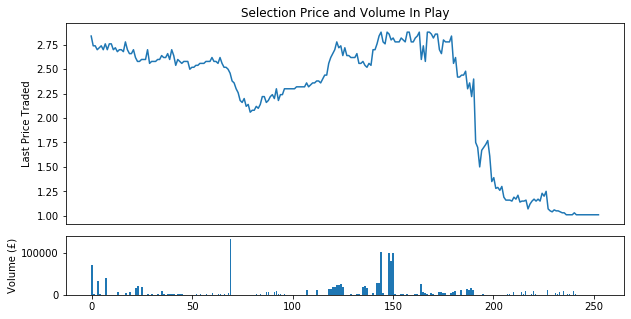

In [27]:
plt.figure(figsize=(10,5))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(df_52106.TimeIndex, df_52106.LastPriceTraded) 
bottom.bar(df_52106.TimeIndex, df_52106.TradeSize) 

top.axes.get_xaxis().set_visible(False)
top.set_title('Selection Price and Volume In Play')
top.set_ylabel('Last Price Traded')
bottom.set_ylabel('Volume (£)')

HistoricalStream code write version:

In [ ]:
# from betfairlightweight import StreamListener
# from betfairlightweight.streaming.stream import MarketStream

# class HistoricalStream(MarketStream):
#     # create custom listener and stream

#     def __init__(self, listener):
#         super(HistoricalStream, self).__init__(listener)
#         with open("output.txt", "w") as output:
#             output.write("Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,\
#             AdjFactor,RunnerStatus,MktTotalMatched\n")

#     def on_process(self, market_books):
#         with open("output.txt", "a") as output:
#             for market_book in market_books:
#                 for runner in market_book.runners:

#                     # how to get runner details from the market definition
#                     market_def = market_book.market_definition
#                     runners_dict = {
#                         (runner.selection_id, runner.handicap): runner
#                         for runner in market_def.runners
#                     }
#                     runner_def = runners_dict.get(
#                         (runner.selection_id, runner.handicap)
#                     )

#                     output.write(
#                         "%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s\n"
#                         % (
#                             market_book.publish_time, #datetime.datetime
#                             market_book.market_id, #float
#                             market_book.status, #unicode
#                             market_book.inplay, #bool
#                             runner.selection_id, #int
#                             runner.last_price_traded or "", #float
#                             runner.total_matched or "", #float
#                             runner.sp.actual_sp or "", #float
#                             runner.adjustment_factor or "", #float
#                             runner.status,
#                             market_book.total_matched or "", #float
#                         )
#                     )


# class HistoricalListener(StreamListener):
#     def _add_stream(self, unique_id, stream_type):
#         if stream_type == "marketSubscription":
#             return HistoricalStream(self)
        
# listener = HistoricalListener(max_latency=None)

# stream = trading.streaming.create_historical_stream(
#     directory=newfilepath,
#     listener=listener,
# )

# stream.start() #This fills output.txt, after all the above defines its contents